In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
import scipy as sp

In [2]:
from parse import *

## Randomly remove edges

In [140]:
Gg = read_input_file("inputs/small/small-127.in")

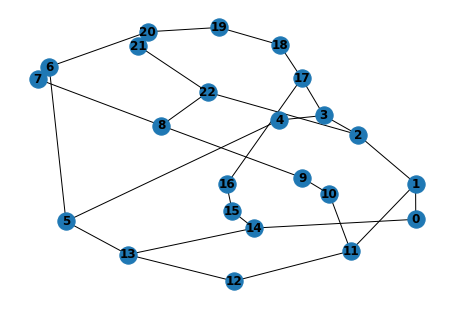

In [141]:
nx.draw(Gg, with_labels=True, font_weight='bold')

In [5]:
l = len(list(Gg.edges))
l

292

In [6]:
sp.special.binom(l, l - 15)

5.074866030134501e+24

In [7]:
nx.dijkstra_path_length(Gg, 0, 29)

25.282

In [8]:
def rem_random(G, k):
    """
    G: graph input
    k: number of random graphs to consider
    """
    v = G.number_of_nodes() - 1
    path = nx.dijkstra_path(G, 0, v)
    longest_min_path = nx.dijkstra_path_length(G, 0, v)
    rm_edges = 0
    rm_node = 0
    
    nodes = np.sort(list(G.nodes))[1:][:-1]
    
    for n in nodes:
        G_prime = nx.Graph(G)
        G_prime.remove_node(n)
        
        G_prime_edges = list(G_prime.edges)
        
        for _ in range(k):
            to_remove = random.sample(G_prime_edges, 15)
            G_prime.remove_edges_from(to_remove)
            
            if nx.is_connected(G_prime):
                new_min_path = nx.dijkstra_path_length(G_prime, 0, v)
        
                if new_min_path > longest_min_path:
                    longest_min_path = new_min_path
                    rm_edges = to_remove
                    path = nx.dijkstra_path(G_prime, 0, v)
                    rm_node = n
            
    return path, longest_min_path, rm_edges, rm_node

In [9]:
r = rem_random(Gg, 50000)
r

KeyboardInterrupt: 

In [ ]:
Gg2 = read_input_file("inputs/small/small-8.in")

In [ ]:
r2 = rem_random(Gg2, 50000)
r2

In [ ]:
print("This graph has", Gg2.number_of_nodes(), "nodes and", Gg2.number_of_edges(), "edges")

nx.draw(Gg2, with_labels=True, font_weight='bold');

In [29]:
nx.dijkstra_path_length(Gg2, 0, 29)

34.0

## Rank edge based on heuristics

In [155]:
Gg = read_input_file("inputs/large/large-127.in")

In [117]:
import heapq
from itertools import permutations 


In [118]:
def dijsktra_path(G):
    node_count = len(G.nodes)
    path = nx.dijkstra_path(G, 0, node_count - 1)
    print(path)
    edge = [(path[i], path[i + 1]) for i in range(len(path) - 1)]
    return edge

In [ ]:
def score_components(Gg):
    dj_path = dijsktra_path(Gg)
    weight = []
    conn = []
    score = []
    in_shortest_path = []
    num_nodes = len(Gg.nodes)
    
    edges = Gg.edges.data()
    for u, v, prop in edges:
        conn.append(Gg.degree[u] + Gg.degree[v] - 2)
        weight.append(prop['weight'])
        if (u,v) in dj_path:
            in_shortest_path.append(0.8) #tune this weight
        else:
            in_shortest_path.append(0)
    
    #normalize score 
    min_weight = min(weight)
    max_conn = max(conn)
    weight = [min_weight/w for w in weight] #less than 1
    conn  = [c/max_conn for c in conn] #less than 1
    
    #calculate edge score
    e_score = np.array([conn[i] + weight[i] * 1.5 + in_shortest_path[i] for i in range(len(edges))])

    #add attribute e_score to each edge
    nx.set_edge_attributes(Gg, {e: {'score': e_score[i]} for i,e in enumerate(Gg.edges)})

    #calc score of node based on collective sum of e_score 
    n_score = []
    for i, node in enumerate(Gg.nodes):
        prop = Gg.edges(node, data='score')
        score = sum(i[2] for i in prop) / len(prop)
        n_score.append(score)
    
    # rank edges:
    edges = list(Gg.edges)
    argsort = np.argsort(np.array(e_score))
    sorted_edge = [edges[i] for i in argsort]
    sorted_node = np.argsort(np.array(n_score))
    sorted_node = sorted_node[sorted_node != 0]
    sorted_node = sorted_node[sorted_node != num_nodes - 1]
    return sorted_edge, sorted_node
    
def heuristics_plain(G, cnum, knum):
    """
    Args:
        G: networkx.Graph
    Returns:
        c: list of cities to remove
        k: list of edges to remove
    """
    G_cut = G.copy()
    sorted_edge, sorted_node = score_components(G_cut)
    c, k = [], []


    for n in sorted_node:
        copy = G_cut.copy()
        copy.remove_node(n)
        if nx.is_connected(copy):
            cnum -= 1
            c.append(n)
            G_cut = copy
        if cnum == 0:
            break

    for u, v in sorted_edge:
        if u not in c and v not in c:
            G_cut.remove_edge(u, v)
            if nx.is_connected(G_cut):
                knum -= 1 
                k.append((u, v))
            else:
                G_cut.add_edge(u, v)
        if knum == 0:
            break
    
    return c, k

def heuristics_greedy(G, cnum, knum):
    
    G_cut = G.copy()
    sorted_edge, sorted_node = score_components(G_cut)
    sorted_node = sorted_node[:30]
    c, k = [], []
    
    while len(c) < cnum:
        score_node = max(sorted_node, key=lambda x: calculate_score(G, c + [x], k))
        c.append(score_node)
        
    
    sorted_edge =list(filter(lambda e: e[0] not in c and e[1] not in c, sorted_edge))
    print(c)
    
    while len(k) < knum:
        
        sorted_edge = list(filter(lambda x: is_valid_solution(G, c, k + [x]), sorted_edge))
        print(len(sorted_edge))
        score_edge = max(sorted_edge, key=lambda x: calculate_score(G, c, k + [x]))
        k.append(score_edge)
        print(k)
        sorted_edge.remove(score_edge)
    
    return c, k
        

def look_advace_small(G, cnum, knum, beamSize):
    
    
    G_cut = G.copy()
    sorted_edge, sorted_node = score_components(G_cut)
    sorted_node = sorted_node[:30]
    c, k = [], []
    
    while len(c) < cnum:
        score_node = max(sorted_node, key=lambda x: calculate_score(G, c + [x], k))
        c.append(score_node)
    
    sorted_edge =list(filter(lambda e: e[0] not in c and e[1] not in c, sorted_edge))
    sorted_edge = list(filter(lambda x: is_valid_solution(G, c, k + [x]), sorted_edge))
    nlargest = heapq.nlargest(beamSize, sorted_edge, key=lambda x: calculate_score(G, c, k + [x]))
    
    beams = [[[x for x in sorted_edge if x != i], [i], calculate_score(G, c, [i])] for i in nlargest] # [list_of_edges, k, score]
    
    k_tracker = 0
    while k_tracker < knum:
        new_beams = []
        # curate new beams 
        for b in beams:
            b[0] = list(filter(lambda x: is_valid_solution(G, c, b[1] + [x]), b[0]))
            nlargest = heapq.nlargest(beamSize, b[0], key=lambda x: calculate_score(G, c, b[1] + [x]))
            for i in nlargest:
                new_beams.append([[x for x in b[0] if x != i], b[1] + [i], calculate_score(G, c, b[1] + [i])])
            
        beams = heapq.nlargest(beamSize, new_beams, key=lambda x: x[2])
                        
        k_tracker += 1
    
    best = max(beams, key=lambda x:x[2])
    

    return c, best[1], best[2]

def dj_beam_search(G, cnum, knum, beamSize):
    print('hey!')
    c, k = [], []
    edges = list(G.edges)
    node_count = len(G.nodes)
    nodes = list(Gg.nodes)
    nodes.remove(0)
    nodes.remove(node_count - 1)
    
    
    G_copy = G.copy()
    beams = [[[], []]]  #[c, k, score]
    k_count = 0
    print('aye')
    while k_count < knum - 1:
        new_beams = []
        for b in beams:
            shortest = dijsktra_path_(G.copy(), b[0], b[1])
            shortest = list(filter(lambda x: is_valid_solution(G_copy, b[0], b[1] + [x]), shortest))
            best_edges = heapq.nlargest(beamSize, shortest, key=lambda x: calculate_score(G_copy, b[0], b[1] + [x]))
            for i in best_edges:
                new_beams.append([b[0], b[1] + [i], calculate_score(G_copy, b[0], b[1] + [i])])
            if len(best_edges) == 0:
                new_beams.append(b)
            
        beams = heapq.nlargest(beamSize, new_beams, key=lambda x: x[2]) #beamsize * 2?
        
        k_count += 1 
    print('-')
#     forbidden_node = [n for n in nodes if not is_valid_solution(G_copy, [n], [])]
#     print(forbidden_node)
    
    print('stage b')
    print(beams)
    #remove node that has high overlap
    new_beams = []
    for b in beams:
        overlap = {}
        
        edges = b[1]
        for i in edges:
            if i[0] not in overlap:
                overlap[i[0]] = 1
            elif i[1] not in overlap:
                overlap[i[1]] = 1
            else:
                overlap[i[1]] += 1
                overlap[i[0]] += 1
        overlap.pop(0,None)
        overlap.pop(node_count - 1,None)
        
                
        sorted_node = heapq.nlargest(beamSize, overlap.keys(), key=lambda x: overlap[x])
        
    
        node_perm = list(permutations(sorted_node, cnum))
        node_perm = list(filter(lambda x: is_valid_solution(G_copy, x, b[1]), node_perm))
        sorted_node_perm = heapq.nlargest(beamSize, node_perm, key=lambda x: calculate_score(G_copy, x, edges))

        for c in sorted_node_perm:
            new_beams.append([c, edges, calculate_score(G_copy, c, edges)])
        if len(sorted_node_perm) == 0:
            new_beams.append([[], edges, calculate_score(G_copy, [], edges)])
    
    beams = heapq.nlargest(beamSize * 2, new_beams, key=lambda x: x[2])
    print('stage c')
    print(beams)
    
    #remove edges that overlap with node
    for b in beams:
        b[1] =list(filter(lambda e: e[0] not in b[0] and e[1] not in b[0], b[1]))
        print(len(b[1]))
        
    
    #add edge till limit is reached
    
    done = []
    print(beams)
    
    while len(done) < beamSize:
        new_beams = []
        for b in beams:
            if len(b[1]) == knum:
                done.append(b)
            else:
                shortest = dijsktra_path_(G.copy(), b[0], b[1])
                shortest = list(filter(lambda x: is_valid_solution(G_copy, b[0], b[1] + [x]), shortest))
                shortest =list(filter(lambda e: e[0] not in b[0] and e[1] not in b[0], shortest))
                best_edges = heapq.nlargest(beamSize, shortest, key=lambda x: calculate_score(G_copy, b[0], b[1] + [x]))
                for i in best_edges:
                    new_beams.append([b[0], b[1] + [i], calculate_score(G_copy, b[0], b[1] + [i])])
                print(best_edges)
                if len(best_edges) == 0:
                    new_beams.append(b)
        if beams == new_beams:
            done.extend(new_beams)
        beams = heapq.nlargest(beamSize * 2, new_beams, key=lambda x: x[2]) #beamsize * 2?
    
    
    best = max(done, key=lambda x:x[2])
    
    return best

    
    

        
    
    
        
    
    
    
dj_beam_search(Gg, 5, 100, 6)

    
    
    
    



    

hey!
aye
-
stage b
[[[], [(23, 63), (0, 32), (39, 38), (3, 4), (45, 34), (55, 56), (26, 27), (54, 34), (22, 21), (34, 10), (19, 18), (15, 58), (48, 49)], 1860.86], [[], [(23, 63), (0, 32), (39, 38), (3, 4), (45, 34), (55, 56), (26, 27), (54, 34), (22, 21), (34, 10), (19, 18), (15, 58), (49, 50)], 1860.86], [[], [(23, 63), (0, 32), (39, 38), (3, 4), (45, 34), (55, 56), (26, 27), (54, 34), (22, 21), (34, 10), (19, 18), (15, 58), (50, 51)], 1860.86], [[], [(23, 63), (0, 32), (39, 38), (3, 4), (45, 34), (55, 56), (26, 27), (54, 34), (22, 21), (34, 10), (19, 18), (15, 58), (51, 52)], 1860.86], [[], [(23, 63), (0, 32), (39, 38), (3, 4), (45, 34), (55, 56), (26, 27), (54, 34), (22, 21), (34, 10), (19, 18), (58, 59), (48, 49)], 1860.86], [[], [(23, 63), (0, 32), (39, 38), (3, 4), (45, 34), (55, 56), (26, 27), (54, 34), (22, 21), (34, 10), (19, 18), (58, 59), (49, 50)], 1860.86]]


## Utils

In [12]:
def calculate_score(G, c, k):
    """
    Calculates the difference between the original shortest path and the new shortest path.
    Args:
        G: networkx.Graph
        c: list of cities to remove
        k: list of edges to remove
    Returns:
        float: total score
    """
    H = G.copy()
    assert is_valid_solution(H, c, k)
    node_count = len(H.nodes)
    original_min_dist = nx.dijkstra_path_length(H, 0, node_count-1)
    H.remove_edges_from(k)
    H.remove_nodes_from(c)
    final_min_dist = nx.dijkstra_path_length(H, 0, node_count-1)
    difference = final_min_dist - original_min_dist
    return difference

In [85]:
def calculate_score_(G, c, k):
    H = G.copy()
    if not is_valid_solution(H, c, k):
        return 0
    node_count = len(H.nodes)
    original_min_dist = nx.dijkstra_path_length(H, 0, node_count-1)
    H.remove_edges_from(k)
    H.remove_nodes_from(c)
    final_min_dist = nx.dijkstra_path_length(H, 0, node_count-1)
    difference = final_min_dist - original_min_dist
    return difference

In [13]:
def is_valid_solution(G, c, k):
    """
    Checks whether D is a valid mapping of G, by checking every room adheres to the stress budget.
    Args:
        G: networkx.Graph
        c: List of cities to remove
        k: List of edges to remove (List of tuples)
    Returns:
        bool: false if removing k and c disconnects the graph
    """
    size = len(G)
    H = G.copy()
    for road in k:
        assert H.has_edge(road[0], road[1]), "Invalid Solution: {} is not a valid edge in graph G".format(road)
    H.remove_edges_from(k)
    
    for city in c:
        assert H.has_node(city), "Invalid Solution: {} is not a valid node in graph G".format(city)
    H.remove_nodes_from(c)
    
    assert H.has_node(0), 'Invalid Solution: Source vertex is removed'
    assert H.has_node(size - 1), 'Invalid Solution: Target vertex is removed'

    return nx.is_connected(H)

In [63]:
def dijsktra_path_(G, c , k):
    G.remove_edges_from(k)
    G.remove_nodes_from(c)
    node_count = len(G.nodes)
    path = nx.dijkstra_path(G, 0, node_count - 1)
#     print(path)
    edge = [(path[i], path[i + 1]) for i in range(len(path) - 1)]
    return edge